<a href="https://colab.research.google.com/github/deepsharma26/SIRT-isoform_selective-/blob/main/Per_residue_energy_decomposition_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Per-residues energy contribution plot after decomposition analysis using gmx_MMPBSA


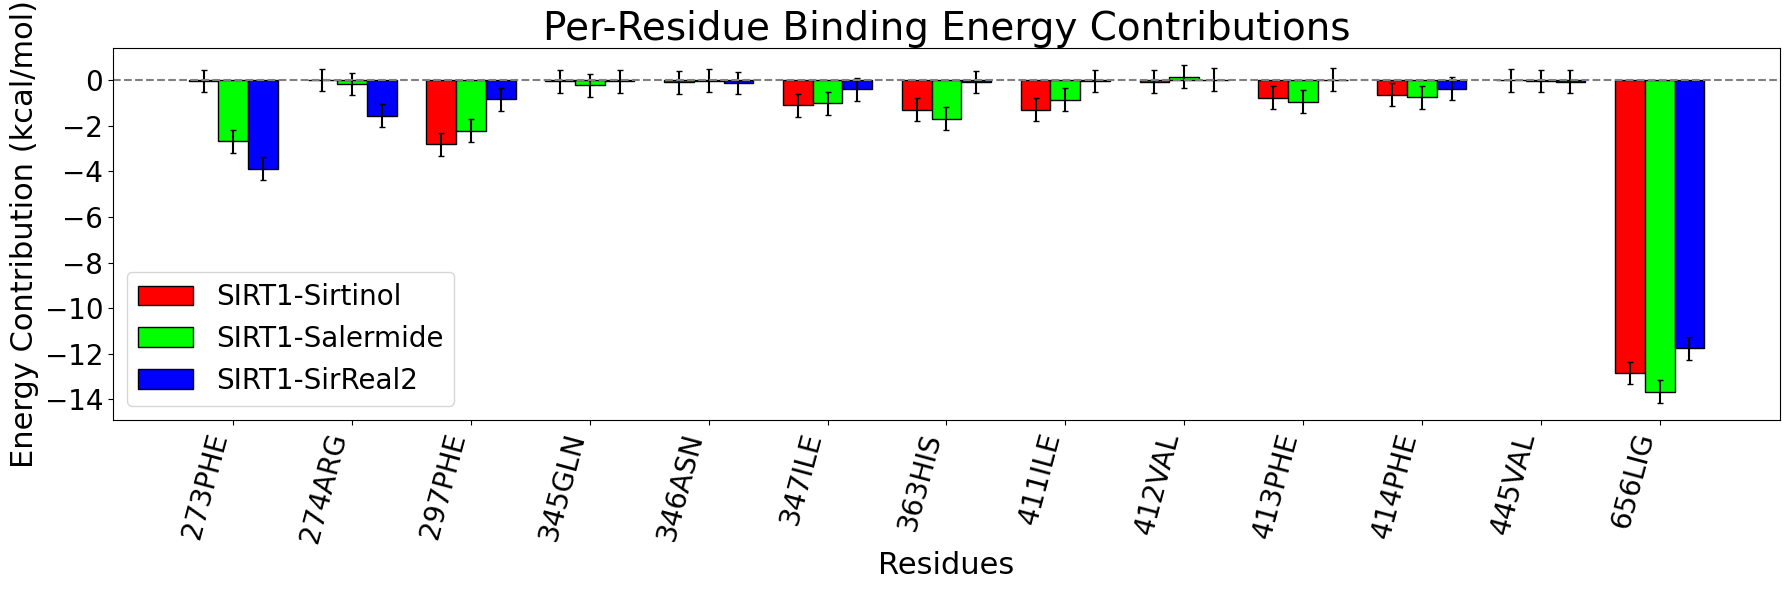

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# === Setup input files, colors, and labels ===
files_info = [
    ("SIRT1_2827_FINAL_DECOMP_MMPBSA.dat", "red", "SIRT1-Sirtinol"),
    ("SIRT1_1356_FINAL_DECOMP_MMPBSA.dat", "lime", "SIRT1-Salermide"),
    ("SIRT1_1096_FINAL_DECOMP_MMPBSA.dat", "blue", "SIRT1-SirReal2"),
]

def extract_total_decomp(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    start_index = None
    for i in range(len(lines)):
        if lines[i].strip().startswith("DELTAS:") and "Total Energy Decomposition" in lines[i + 1]:
            start_index = i + 4  # Skip headers
            break
    if start_index is None:
        raise ValueError(f"Could not find decomposition block in {file_path}")

    residue = []
    avg = []
    std = []

    for line in lines[start_index:]:
        if not line.strip(): break
        parts = line.strip().split(',')
        try:
            rid = parts[0].strip().split(':')[-1] + parts[0].strip().split(':')[-2]  # e.g., ARG274
            avg_val = float(parts[-3])
            std_val = float(parts[-2])
        except (IndexError, ValueError):
            continue

        residue.append(rid)
        avg.append(avg_val)
        std.append(std_val)

    df = pd.DataFrame({'Residue': residue, 'Avg': avg, 'Std': std})
    return df

# === Extract and merge data from all complexes ===
dfs = []
for file, color, label in files_info:
    df = extract_total_decomp(file)
    df = df.set_index("Residue")
    df = df.rename(columns={"Avg": f"{label}_Avg", "Std": f"{label}_Std"})
    dfs.append(df)

# === Combine by common residues ===
merged = pd.concat(dfs, axis=1, join='inner')
merged = merged.sort_index()

# === Clip long error bars ===
error_cap = 0.5  # kcal/mol
for label in [x[2] for x in files_info]:
    merged[f"{label}_Std"] = merged[f"{label}_Std"].clip(upper=error_cap)

# === Saving the merged file ===
merged.to_csv("SIRT1_decomposition_merged.csv")

# === Plot ===
x = np.arange(len(merged.index))
width = 0.25

plt.figure(figsize=(18, 6))

for idx, (file, color, label) in enumerate(files_info):
    plt.bar(x + idx * width,
            merged[f"{label}_Avg"],
            width,
            yerr=merged[f"{label}_Std"],
            capsize=2,
            label=label,
            color=color,
            edgecolor='black')

plt.xticks(x + width, merged.index, rotation=75, ha='right', fontsize=20)
plt.yticks(fontsize=20),
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Residues", fontsize=22)
plt.ylabel("Energy Contribution (kcal/mol)", fontsize=22)
plt.title("Per-Residue Binding Energy Contributions", fontsize=28)
plt.legend()
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("SIRT1_decmposition.png", dpi=300)
plt.show()